In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os, sys
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torch
from torch.nn import functional as F
import torch.optim as optim

# Data pipeline
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples, pad_sequences,
    build_user_table, build_movie_table
)

# Dataset wrapper
from data_utils.datasets import MFTrainDataset, FeatureAwareDeepMFDataset

# Model and evaluation
from models.matrix_factorization import MatrixFactorization, DeepMF, FeatureAwareDeepMF
from evaluation import evaluate_ranking_model

ImportError: cannot import name 'FeatureAwareDeepMF' from 'models.matrix_factorization' (/Users/rishisadhir/Documents/OMSC/DL/recommender-system/models/matrix_factorization.py)

In [8]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on", device)

Running on mps


## Data preprocessing

1.	Load raw data
Reads MovieLens “ratings”, “users” and “movies” files into pandas DataFrames.
2.	Clean & filter
• Drops ratings for nonexistent movies
• Keeps only ratings ≥ threshold (default 4)
• Converts Unix timestamps to datetime
3.	Build user timelines
Sorts each user’s interactions by time and collects their movie‑ID sequence.
4.	Split sequences
For each user with ≥ 3 events, chops their list into train, validation and test segments (by ratios 0.8/0.1/0.1).
5.	Construct training examples
For every prefix of length ≥ 2 in each user’s train split, emits one example comprising:
    - the prefix
    - the next (positive) item
    - K randomly sampled negatives (items the user never saw)
6.	Pad & mask
Right‐pad each prefix to a fixed length (max_len, default 50) with 0s, and build a matching binary mask.
7.	Build side‐feature tables
    - Users: bucket ages, drop ZIP, one‐hot encode gender & occupation
    - Movies: one‐hot encode genres, extract release year from title

At the end you have:
- A list of prefix / positive / negative examples, all padded for model input
- Dense user and movie feature tables for any tabular model components.

In [40]:
data_dir = "../data"
# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
ratings, users, movies = clean_and_filter(ratings, users, movies, rating_threshold=4)

# 2) build per-user sequences & splits
user_seqs   = get_user_sequences(ratings)
user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

# 3) global item set
all_movies = set(movies["MovieID"].unique())

# 4) build examples for train/val
train_exs = build_examples(user_splits, all_movies, K=5, split="train")
val_exs   = build_examples(user_splits, all_movies, K=5, split="val")
test_exs   = build_examples(user_splits, all_movies, K=5, split="test")

# 5) pad to fixed length
max_len   = 50
train_exs = pad_sequences(train_exs, max_len=max_len)
val_exs   = pad_sequences(val_exs, max_len=max_len)
test_exs  = pad_sequences(test_exs, max_len=max_len)

print(f"Train examples: {len(train_exs)},  Val examples: {len(val_exs)}")

Train examples: 445746,  Val examples: 51222


In [31]:
movies.head()

,MovieID,Title,Genres
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy


Each example in train_exs now has:
- `ex["padded_prefix"]` → np.array of shape (max_len,)
- `ex["mask"]`          → np.array of 0/1 mask of shape (max_len,)
- `ex["positive"]`      → scalar item ID
- `ex["negatives"]`     → list of K sampled negatives that are dense movie_ids

In [11]:

# These take your raw `users` and `movies` DataFrames
user_tab  = build_user_table(users)
movie_tab = build_movie_table(movies)

# `user_tab` will have one‑hot cols for Gender & Occupation, plus AgeBucket.
# `movie_tab` will have multi‑hot genre columns and a Year column, plus Title.

In [24]:
movie_tab.head()

,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Year
0,0,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,1,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,2,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,3,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,4,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [12]:
movie_tab.head()

,MovieID,Title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Year
0,0,Toy Story,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,1,Jumanji,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,2,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,3,Waiting to Exhale,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1995
4,4,Father of the Bride Part II,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


- `user_tab` will have one‑hot cols for Gender & Occupation, plus AgeBucket.
- `movie_tab` will have multi‑hot genre columns and a Year column, plus Title.

In [13]:
# These are lookup arrays that can be dropped in to your Dataset __getitem__:
user_feat_mat  = user_tab.drop("UserID", axis=1).values   # (n_users, n_user_feats)
movie_feat_mat = movie_tab.drop(["MovieID","Title"], axis=1).values  # (n_movies, n_movie_feats)
# u_feats = torch.tensor(user_feat_mat[user_idx], dtype=torch.float)
# i_feats = torch.tensor(movie_feat_mat[movie_idx], dtype=torch.float)

## Matrix Factorization (MF)

- **Goal**  
  Approximate the user–item interaction matrix \(R\) by two low‑rank factors:  
  $$R \approx U\,V^{T}$$

- **Embeddings**  
  - $U \in \mathbb{R}^{n_{\text{users}}\times k}$: each row $u_{i}$ is a $k$‑dimensional user vector  
  - $V \in \mathbb{R}^{n_{\text{items}}\times k}$: each row $v_{j}$ is a $k$‑dimensional item vector  

- **Prediction**  
  $$\hat r_{i,j} = u_{i}\cdot v_{j}
    = \sum_{\ell=1}^{k} U_{i,\ell}\,V_{j,\ell}$$

- **Training objectives**  
  - **Pairwise (BPR)**  
    $$\min_{U,V}\;
      -\sum_{(i,p,n)} \ln\sigma\bigl(\hat r_{i,p} - \hat r_{i,n}\bigr)$$

- **Why it works**  
  1. Learns compact “taste” factors without explicit features  
  2. Compresses a large, sparse matrix into dense vectors  
  3. Enables very fast inference via a simple dot‑product  

In [36]:
batch_size = 1024

train_ds = MFTrainDataset(train_exs, num_negatives=1)
val_ds   = MFTrainDataset(val_exs,   num_negatives=1)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

num_users = len(users)
num_items = len(movies)

mf        = MatrixFactorization(num_users, num_items, embedding_dim=32).to(device)
optimizer = optim.Adam(mf.parameters(), lr=1e-3)

def bpr_loss(pos_scores, neg_scores):
    return -(pos_scores - neg_scores).sigmoid().log().mean()

print("Batches per epoch:", len(train_loader))


Batches per epoch: 436


In [15]:
unique_ids = {
    int(ex["positive"]) for ex in train_exs
}.union({
    int(ex["negatives"][0]) for ex in train_exs
})
len(unique_ids), max(unique_ids), min(unique_ids)

(3883, 3882, 0)

In [16]:
unique_ids = {
    int(ex["UserID"]) for ex in train_exs
}
len(unique_ids), max(unique_ids), min(unique_ids)

(6035, 6039, 0)

Epoch 1/3 — Train: 3.1731, Val: 3.0958
Epoch 2/3 — Train: 2.9151, Val: 2.9489
Epoch 3/3 — Train: 2.6791, Val: 2.8117


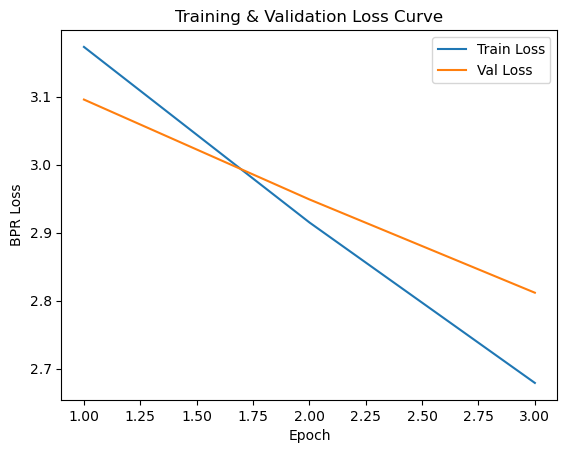

In [17]:
epochs = 3
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # ——— train ———
    mf.train()
    tot_train = 0.0
    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)
        optimizer.zero_grad()
        loss = bpr_loss(mf(user, pos), mf(user, neg))
        loss.backward()
        optimizer.step()
        tot_train += loss.item()
    avg_train = tot_train / len(train_loader)
    train_losses.append(avg_train)

    # ——— val ———
    mf.eval()
    tot_val = 0.0
    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)
            tot_val += bpr_loss(mf(user, pos), mf(user, neg)).item()
    avg_val = tot_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")

# Cell 6: plot curves
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

### Evaluation Procedure

#### 1. Metrics definitions
- **Hit@K**  
  Returns 1 if the true (positive) item is ranked $\le K$, else 0.
- **NDCG@K**  
  Returns $\displaystyle \frac{1}{\log_{2}(\mathrm{rank}+1)}$ if $\mathrm{rank}\le K$, else 0.
- **MRR** (Mean Reciprocal Rank)  
  $\displaystyle \mathrm{MRR} = \frac{1}{\mathrm{rank}}$
- **MAP** (Mean Average Precision)  
  For a single positive item, $\mathrm{AP} = \frac{1}{\mathrm{rank}}$

#### 2. Negative sampling
Given a user prefix (items in train + validation) and the global item set, sample $(\mathrm{candidate\_size} - 1)$ negatives uniformly from items the user hasn’t seen.

#### 3. Per‑user evaluation loop
For each user with at least one test item:  
1. **Build prefix** = `train_seq + val_seq`  
2. **Held‑out positive** = `test_seq[0]`  
3. **Sample negatives** (size = candidate_size – 1) excluding prefix & positive  
4. **Candidates** = `[positive] + negatives`  
5. **Score all candidates** in one forward pass:  
   ```python
   users_t = torch.tensor([user] * candidate_size, dtype=torch.long, device=device)
   items_t = torch.tensor(candidates,         dtype=torch.long, device=device)
   scores  = model(users_t, items_t).cpu().numpy()

In [18]:
metrics = evaluate_ranking_model(
    model=mf,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.0900
- NDCG@10: 0.0395
- MRR: 0.0474
- MAP: 0.0474


Lets see which movies are similar to toy story

In [19]:
toy_story_emb = mf.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(mf.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                                            Title  similarity
0           0                                 Toy Story (1995)    1.000000
131       131                                 Nueba Yol (1995)    0.578632
314       314                         Santa Clause, The (1994)    0.571816
479       479                          King of the Hill (1993)    0.567855
1916     1916  Halloween 4: The Return of Michael Myers (1988)    0.531798
2231     2231                            Producers, The (1968)    0.504000
2540     2540            King of Masks, The (Bian Lian) (1996)    0.492970
2742     2742                With Friends Like These... (1998)    0.489355
2991     2991                          Commitments, The (1991)    0.482694
3297     3297                         Where Eagles Dare (1969)    0.480055
3640     3640                              Sleepwalkers (1992)    0.479060


/var/folders/pt/4cr2zr794g717_kmql57h7qw0000gn/T/ipykernel_72885/2216239250.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores


## Fancier matrix factorization

We're now going to use an MLP instead of dot product. This brings us into deepMF territory. The set up is nearly identical so we can reuse the same data objects as before.

Epoch 1/3 | Train Loss: 0.4640 | Val Loss: 0.4258
Epoch 2/3 | Train Loss: 0.3040 | Val Loss: 0.3850
Epoch 3/3 | Train Loss: 0.2839 | Val Loss: 0.3785


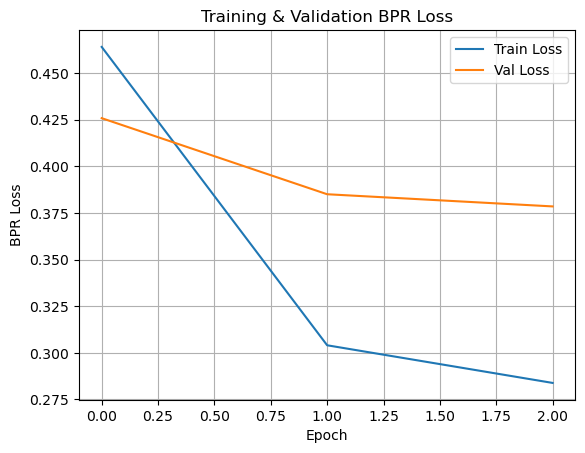

In [20]:
emb_dim = 32

train_losses, val_losses = [], []
model = DeepMF(num_users, num_items, emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_train_loss = 0.0

    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)

        optimizer.zero_grad()
        pos_score = model(user, pos)
        neg_score = model(user, neg)

        loss = -F.logsigmoid(pos_score - neg_score).mean()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)

            pos_score = model(user, pos)
            neg_score = model(user, neg)

            val_loss = -F.logsigmoid(pos_score - neg_score).mean()
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation BPR Loss")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from torch.nn import functional as F
toy_story_emb = model.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(model.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                                       Title  similarity
0           0                            Toy Story (1995)    1.000000
731       731  Ghost in the Shell (Kokaku kidotai) (1995)    0.595998
851       851                           Manny & Lo (1996)    0.574478
1394     1394              Portrait of a Lady, The (1996)    0.551457
1702     1702                        Shooting Fish (1997)    0.535397
2001     2001                       Tender Mercies (1983)    0.518650
2290     2290                    Waking Ned Devine (1998)    0.496954
2812     2812                      Double Jeopardy (1999)    0.489778
3144     3144         Batman: Mask of the Phantasm (1993)    0.489458
3351     3351               ...And Justice for All (1979)    0.484630
3810     3810         Ballad of Ramblin' Jack, The (2000)    0.484415


/var/folders/pt/4cr2zr794g717_kmql57h7qw0000gn/T/ipykernel_72885/1490599772.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores


# Now lets add features to deepMF

Wrap the model in a scorer. This way the evaluation pipeline doesn't need to reason about features.


In [41]:
# Gender vocab
gender_vocab = {g: i for i, g in enumerate(users["Gender"].unique())}

# Occupation vocab
occ_vocab = {o: i for i, o in enumerate(sorted(users["Occupation"].unique()))}

# Normalize age
min_age, max_age = users["Age"].min(), users["Age"].max()

# Build user_feat
user_feat = {}
for _, row in users.iterrows():
    uid = row["UserID"]
    gender_id = gender_vocab[row["Gender"]]
    occ_id = occ_vocab[row["Occupation"]]
    age_val = (row["Age"] - min_age) / (max_age - min_age)
    user_feat[uid] = (occ_id, age_val, gender_id)

In [42]:
import numpy as np
import pandas as pd

# Genre vocab
all_genres = set()
for g in movies["Genres"]:
    all_genres.update(g.split("|"))
genre_vocab = {g: i for i, g in enumerate(sorted(all_genres))}

# Normalize year
movies[["Title", "Year"]] = movies["Title"].str.extract(r'^(.*) \((\d{4})\)$')
movies = movies.dropna(subset=["Year"])
movies["Year"] = movies["Year"].astype("int")
min_year, max_year = movies["Year"].min(), movies["Year"].max()

# Build movie feature dicts
movie_genre_vec = {}
movie_year = {}

for _, row in movies.iterrows():
    mid = row["MovieID"]
    genre_ids = [genre_vocab[g] for g in row["Genres"].split("|")]
    vec = np.zeros(len(genre_vocab), dtype="float32")
    vec[genre_ids] = 1.0
    movie_genre_vec[mid] = vec
    movie_year[mid] = (row["Year"] - min_year) / (max_year - min_year)

In [ ]:
train_ds = FeatureAwareDeepMFDataset(train_examples, user_feat, movie_genre_vec, movie_year)
val_ds   = FeatureAwareDeepMFDataset(val_examples,   user_feat, movie_genre_vec, movie_year)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False, drop_last=False)

{0: (10, 0.0, 0),
 1: (16, 1.0, 1),
 2: (15, 0.43636363636363634, 1),
 3: (7, 0.8, 1),
 4: (20, 0.43636363636363634, 1),
 5: (9, 0.8909090909090909, 0),
 6: (1, 0.6181818181818182, 1),
 7: (12, 0.43636363636363634, 1),
 8: (17, 0.43636363636363634, 1),
 9: (1, 0.6181818181818182, 0),
 10: (1, 0.43636363636363634, 0),
 11: (12, 0.43636363636363634, 1),
 12: (1, 0.8, 1),
 13: (0, 0.6181818181818182, 1),
 14: (7, 0.43636363636363634, 1),
 15: (0, 0.6181818181818182, 0),
 16: (1, 0.8909090909090909, 1),
 17: (3, 0.3090909090909091, 0),
 18: (10, 0.0, 1),
 19: (14, 0.43636363636363634, 1),
 20: (16, 0.3090909090909091, 1),
 21: (15, 0.3090909090909091, 1),
 22: (0, 0.6181818181818182, 1),
 23: (7, 0.43636363636363634, 0),
 24: (4, 0.3090909090909091, 1),
 25: (7, 0.43636363636363634, 1),
 26: (11, 0.43636363636363634, 1),
 27: (1, 0.43636363636363634, 0),
 28: (7, 0.6181818181818182, 1),
 29: (7, 0.6181818181818182, 0),
 30: (7, 1.0, 1),
 31: (0, 0.43636363636363634, 0),
 32: (3, 0.8, 1),
 